In [ ]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import shutil
import random
from PIL import Image
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.utils import class_weight

In [2]:
df = pd.read_csv("./archive(1)/HAM10000_metadata.csv")
df.head(10)

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
5,HAM_0001466,ISIC_0027850,bkl,histo,75.0,male,ear
6,HAM_0002761,ISIC_0029176,bkl,histo,60.0,male,face
7,HAM_0002761,ISIC_0029068,bkl,histo,60.0,male,face
8,HAM_0005132,ISIC_0025837,bkl,histo,70.0,female,back
9,HAM_0005132,ISIC_0025209,bkl,histo,70.0,female,back


In [ ]:
def redimensionar(size, input_base, ruta_salida):  
# Ruta donde se guardarán las imágenes redimensionadas
  output_base = ruta_salida
  os.makedirs(output_base, exist_ok=True)

  # Tamaño
  size = (size, size)

  for img_name in os.listdir(input_base):
    try:
        img_path = os.path.join(input_base, img_name)
        img = Image.open(img_path).convert('RGB')
        img = img.resize(size, Image.LANCZOS)
        img.save(os.path.join(output_base, img_name))
        print(f'Imagen {img_name} redimensionada y guardada en {output_base}')
    except Exception as e:
        print(f'Error en {img_name}: {e}')
      

#redimensionar(224, './archive(1)/HAM10000_images_part_1', "./redimension")
redimensionar(224, './archive(1)/HAM10000_images_part_2', "./redimension")


In [25]:
df = pd.read_csv("./archive(1)/HAM10000_metadata.csv")

# Ruta donde están las imágenes
img_dir = "./redimension"

# Ruta donde se crearán las carpetas por categoría
output_dir = "./redimension_categorias"
os.makedirs(output_dir, exist_ok=True)

# Crear carpetas por cada categoría en dx
for categoria in df['dx'].unique():
    os.makedirs(os.path.join(output_dir, categoria), exist_ok=True)

for idx, row in df.iterrows():
    categoria = row['dx']
    img_name = row['image_id'] + ".jpg"
    src = os.path.join(img_dir, img_name)
    dst = os.path.join(output_dir, categoria, img_name)
    
    if os.path.exists(src):
        shutil.copy(src, dst)
    else:
        print(f"Imagen no encontrada: {src}")


In [37]:
def dividir_train_test(base_path, source_path):
  train_path = os.path.join(base_path, 'train')
  test_path = os.path.join(base_path, 'test')

  os.makedirs(train_path, exist_ok=True)
  os.makedirs(test_path, exist_ok=True)

  # Dividir cada clase
  # Iterar sobre cada clase del dataset redimensionado
  for class_name in tqdm(os.listdir(source_path)):
      class_dir = os.path.join(source_path, class_name)
      if not os.path.isdir(class_dir):
          continue
    
    # Obtener imágenes y mezclarlas aleatoriamente
      images = os.listdir(class_dir)
      random.shuffle(images)

      n_total = len(images)
      n_train = int(n_total * 0.8)

      train_images = images[:n_train]
      test_images = images[n_train:]

    # Crear subcarpetas por clase

      os.makedirs(os.path.join(train_path, class_name), exist_ok=True)
      os.makedirs(os.path.join(test_path, class_name), exist_ok=True)

      # Copiar imágenes a las carpetas de train y test
      for img in train_images:
          shutil.copy(os.path.join(class_dir, img), os.path.join(train_path, class_name, img))

      for img in test_images:
          shutil.copy(os.path.join(class_dir, img), os.path.join(test_path, class_name, img))

dividir_train_test("./redimension_train_test", "./redimension_categorias")


100%|██████████| 7/7 [00:01<00:00,  6.05it/s]


In [55]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_dir = "redimension_train_test/train"
test_dir = "redimension_train_test/test"

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 8010 images belonging to 7 classes.
Found 2005 images belonging to 7 classes.


In [56]:
# Calcular pesos
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

# Convertir a diccionario
class_weights_dict = dict(enumerate(class_weights))


In [57]:
# Cargar EfficientNetB0
base_model = EfficientNetB0(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # congelar capa base

# Crear modelo secuencial
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(7, activation='softmax')
])


In [58]:
# Compilar el modelo
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', save_best_only=True)
]

In [59]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,384,426 (16.73 MB)

 Trainable params: 332,295 (1.27 MB)

 Non-trainable params: 4,052,131 (15.46 MB)

In [61]:
# Entrenar
model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=10,
    callbacks=callbacks,
    class_weight=class_weights_dict
)

Epoch 1/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step - accuracy: 0.1840 - loss: 2.2089

251/251 ━━━━━━━━━━━━━━━━━━━━ 126s 503ms/step - accuracy: 0.1839 - loss: 2.2090 - val_accuracy: 0.0514 - val_loss: 1.9921
Epoch 2/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step - accuracy: 0.1556 - loss: 2.1960

251/251 ━━━━━━━━━━━━━━━━━━━━ 129s 516ms/step - accuracy: 0.1556 - loss: 2.1960 - val_accuracy: 0.1097 - val_loss: 1.9817
Epoch 3/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 133s 528ms/step - accuracy: 0.1576 - loss: 2.1572 - val_accuracy: 0.0873 - val_loss: 2.0223
Epoch 4/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 133s 530ms/step - accuracy: 0.1524 - loss: 2.0790 - val_accuracy: 0.1112 - val_loss: 1.9969
Epoch 5/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 133s 531ms/step - accuracy: 0.1313 - loss: 2.2344 - val_accuracy: 0.0115 - val_loss: 2.0033


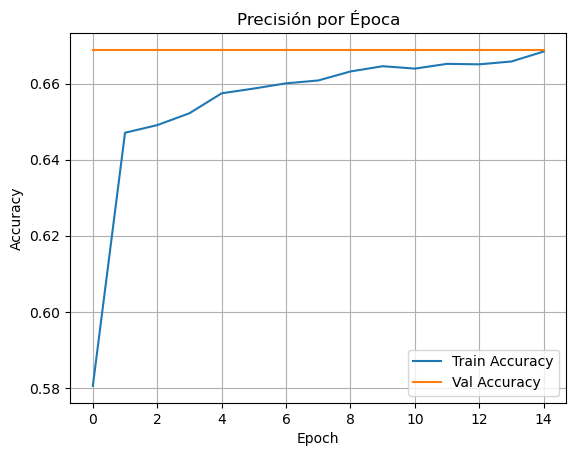

In [63]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Precisión por Época')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


63/63 ━━━━━━━━━━━━━━━━━━━━ 29s 444ms/step
              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00        66
         bcc       0.00      0.00      0.00       103
         bkl       0.00      0.00      0.00       220
          df       0.00      0.00      0.00        23
         mel       0.00      0.00      0.00       223
          nv       0.67      1.00      0.80      1341
        vasc       0.00      0.00      0.00        29

    accuracy                           0.67      2005
   macro avg       0.10      0.14      0.11      2005
weighted avg       0.45      0.67      0.54      2005



/home/felipep/anaconda3/envs/data-science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/felipep/anaconda3/envs/data-science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/felipep/anaconda3/envs/data-science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, 

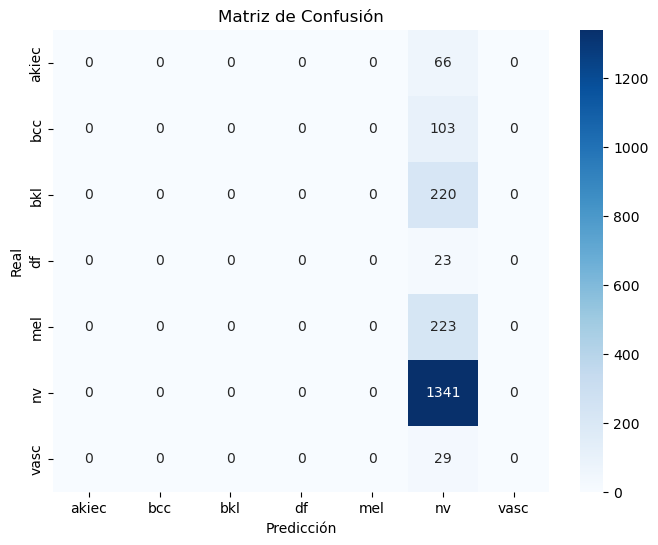

In [52]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Predicciones
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

# Etiquetas verdaderas
y_true = test_generator.classes

# Nombres de clases
class_names = list(test_generator.class_indices.keys())

# Reporte
print(classification_report(y_true, y_pred, target_names=class_names))

# Matriz de confusión
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()
